In [1]:
from IPython.core.display import display, HTML, Markdown

display(HTML("<style>.rendered_html { font-size: 17px; }</style>"))
display(HTML("<style>.container { width:100% !important; }</style>"))

def printmd(string):
    display(Markdown(string))

import pandas as pd
import pybt
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import os
import subprocess
import time
from functools import partial

plt.ion()
%matplotlib inline


try:
    import pybt
except:
    !kinit
    !pip install --user git+https://gitlab.cern.ch/abt-optics-and-code-repository/simulation-codes/pybt.git
    import pybt
    
from cpymad.madx import Madx
from cpymad import libmadx
from multiprocessing import Pool
    

# Madx multiprocessing
The spawn child processces uses cpymad in low-level

In [2]:
mqk = 1.0 
mql = 0.1 
length = 5.3
pc = 1000
madx = None

the trick is that the global `madx` is still private to each child process. Hence an initialization to `None` allows to check on it and start the madx library when first passing by the child

In [3]:
def multimad(kick, start_time):
    global madx
    if not madx:
        print('initializing madx, time is', time.time()-start_time)
        madx = Madx(libmadx=libmadx, stdout=False)
    
        madx.beam(particle='proton', pc=1000)

        madx.command.quadrupole.clone('QF', l=mql, k1=mqk)
        madx.command.quadrupole.clone('QD', l=mql, k1=-mqk)
        madx.command.kicker.clone('kicker')

        madx.command.sequence.clone('s1', l=length)
        madx.elements['qf'].clone('QF1', at=mql/2)
        madx.elements['qd'].clone('QD1', at=length/2-mql/2)
        madx.elements['kicker'].clone('kicker1', at=length/2, hkick='mykick')
        madx.endsequence()

        madx.use('s1')

        madx.select(flag='makethin', class_='quadrupole', slice_=4)
        madx.select(flag='makethin', class_='rbend', slice_=4)
        madx.select(flag='makethin', class_='sextupole', slice_=4)
        madx.makethin(sequence='s1')
        madx.use('s1')

        madx.elements['qd1'].aperture = [2e-3, 9.9]
        madx.elements['qd1'].apertype = 'rectangle'
    else:
        print('no need, madx is already initialized ! time is', time.time()-start_time)

    madx.globals['mykick'] = kick
#     madx.sequence['s1'].elements['kicker1'].hkick = kick

    madx.track(aperture=True, onepass=True, recloss=True, onetable=True)
    
    for val in np.arange(0,3e-3, 0.1e-3):
        madx.start(x=val, y=0, px=0, py=0, t=0, pt=0)
        
    madx.observe(place='qd1')
        
    madx.run(turns=200, maxaper=[1, 1, 1, 1, 1500, 1])
    madx.endtrack()
    

    trackone = madx.table['trackone'].dframe()
    losses = madx.table['trackloss'].dframe()

    return trackone, losses


In [4]:
start_time = time.time()

with Pool(4) as p:
    results = p.map(partial(multimad, start_time=start_time),
                    np.arange(0, 15, 1)*1e-5)


initializing madx, time is 0.0643777847290039
initializing madx, time is 0.06534409523010254
initializing madx, time is 0.06529617309570312
initializing madx, time is 0.06493568420410156
no need, madx is already initialized ! time is 0.11295080184936523
no need, madx is already initialized ! time is 0.12072157859802246
no need, madx is already initialized ! time is 0.133713960647583
no need, madx is already initialized ! time is 0.13485169410705566
no need, madx is already initialized ! time is 0.20723414421081543
no need, madx is already initialized ! time is 0.20766258239746094
no need, madx is already initialized ! time is 0.21420502662658691
no need, madx is already initialized ! time is 0.22159194946289062
no need, madx is already initialized ! time is 0.2299191951751709
no need, madx is already initialized ! time is 0.23638057708740234
no need, madx is already initialized ! time is 0.23944664001464844


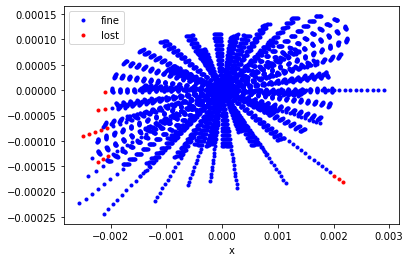

In [5]:
trackone, losses = results[0]
ax = trackone.plot(x='x', y='px', style='b.', label='fine')
losses.plot(ax=ax, x='x', y='px', style='r.', label='lost')

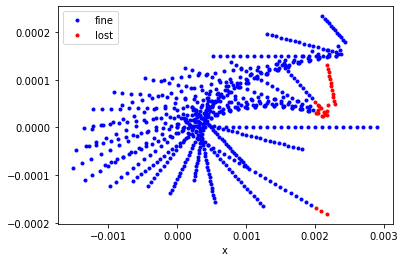

In [6]:
trackone, losses = results[2]
ax = trackone.plot(x='x', y='px', style='b.', label='fine')
losses.plot(ax=ax, x='x', y='px', style='r.', label='lost')

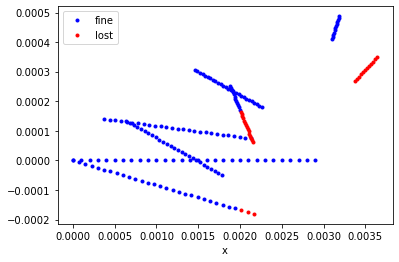

In [7]:
trackone, losses = results[14]
ax = trackone.plot(x='x', y='px', style='b.', label='fine')
losses.plot(ax=ax, x='x', y='px', style='r.', label='lost')

In [8]:
losses

number  turn         x        px    y   py             t   pt    s  \
qd1    28.0   1.0  0.002015 -0.000169  0.0  0.0 -9.140979e-08  0.0  2.6   
qd1    29.0   1.0  0.002090 -0.000175  0.0  0.0 -9.830628e-08  0.0  2.6   
qd1    30.0   1.0  0.002165 -0.000181  0.0  0.0 -1.054535e-07  0.0  2.6   
qd1    13.0   3.0  0.002007  0.000164  0.0  0.0 -1.227703e-07  0.0  2.6   
qd1    14.0   3.0  0.002018  0.000157  0.0  0.0 -1.209893e-07  0.0  2.6   
qd1    15.0   3.0  0.002028  0.000149  0.0  0.0 -1.199197e-07  0.0  2.6   
qd1    16.0   3.0  0.002039  0.000142  0.0  0.0 -1.195614e-07  0.0  2.6   
qd1    17.0   3.0  0.002049  0.000135  0.0  0.0 -1.199146e-07  0.0  2.6   
qd1    18.0   3.0  0.002060  0.000127  0.0  0.0 -1.209792e-07  0.0  2.6   
qd1    19.0   3.0  0.002070  0.000120  0.0  0.0 -1.227552e-07  0.0  2.6   
qd1    20.0   3.0  0.002081  0.000113  0.0  0.0 -1.252425e-07  0.0  2.6   
qd1    21.0   3.0  0.002091  0.000105  0.0  0.0 -1.284413e-07  0.0  2.6   
qd1    22.0   3.0  0.002101  0.000098  0.0  0.0 -1.323515e-07  0.0  2.6   
qd1    23.0   3.0  0.002112  0.000090  0.0  0.0 -1.369731e-07  0.0  2.6   
qd1    24.0   3.0  0.002122  0.000083  0.0  0.0 -1.423062e-07  0.0  2.6   
qd1    25.0   3.0  0.002133  0.000076  0.0  0.0 -1.483506e-07  0.0  2.6   
qd1    26.0   3.0  0.002143  0.000068  0.0  0.0 -1.551064e-07  0.0  2.6   
qd1    27.0   3.0  0.002154  0.000061  0.0  0.0 -1.625736e-07  0.0  2.6   
qd1     1.0   4.0  0.003643  0.000348  0.0  0.0 -5.582186e-07  0.0  2.6   
qd1     2.0   4.0  0.003619  0.000341  0.0  0.0 -5.362657e-07  0.0  2.6   
qd1     3.0   4.0  0.003595  0.000334  0.0  0.0 -5.152475e-07  0.0  2.6   
qd1     4.0   4.0  0.003571  0.000327  0.0  0.0 -4.951638e-07  0.0  2.6   
qd1     5.0   4.0  0.003547  0.000319  0.0  0.0 -4.760148e-07  0.0  2.6   
qd1     6.0   4.0  0.003523  0.000312  0.0  0.0 -4.578003e-07  0.0  2.6   
qd1     7.0   4.0  0.003499  0.000305  0.0  0.0 -4.405203e-07  0.0  2.6   
qd1     8.0   4.0  0.003476  0.000298  0.0  0.0 -4.241750e-07  0.0  2.6   
qd1     9.0   4.0  0.003452  0.000291  0.0  0.0 -4.087642e-07  0.0  2.6   
qd1    10.0   4.0  0.003428  0.000283  0.0  0.0 -3.942881e-07  0.0  2.6   
qd1    11.0   4.0  0.003404  0.000276  0.0  0.0 -3.807465e-07  0.0  2.6   
qd1    12.0   4.0  0.003380  0.000269  0.0  0.0 -3.681394e-07  0.0  2.6   

              e element  
qd1  1000.00044     qd1  
qd1  1000.00044     qd1  
qd1  1000.00044     qd1  
qd1  1000.00044     qd1  
qd1  1000.00044     qd1  
qd1  1000.00044     qd1  
qd1  1000.00044     qd1  
qd1  1000.00044     qd1  
qd1  1000.00044     qd1  
qd1  1000.00044     qd1  
qd1  1000.00044     qd1  
qd1  1000.00044     qd1  
qd1  1000.00044     qd1  
qd1  1000.00044     qd1  
qd1  1000.00044     qd1  
qd1  1000.00044     qd1  
qd1  1000.00044     qd1  
qd1  1000.00044     qd1  
qd1  1000.00044     qd1  
qd1  1000.00044     qd1  
qd1  1000.00044     qd1  
qd1  1000.00044     qd1  
qd1  1000.00044     qd1  
qd1  1000.00044     qd1  
qd1  1000.00044     qd1  
qd1  1000.00044     qd1  
qd1  1000.00044     qd1  
qd1  1000.00044     qd1  
qd1  1000.00044     qd1  
qd1  1000.00044     qd1